In [ ]:
import numpy as np
import random
from shapely.geometry import Polygon, Point
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

In [ ]:
# Define the City class with a distance method
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distance(self, other):
        return np.sqrt((self.x - other.x) ** 2 + (self.y - other.y) ** 2)

In [ ]:
# Define the PSO algorithm
class Particle:
    def __init__(self, route):
        self.route = route
        self.pbest = route
        self.current_cost, self.current_distance, self.current_rotation = self.calculate_total_cost()
        self.pbest_cost = self.current_cost
        self.velocity = []

    def clear_velocity(self):
        self.velocity.clear()

    def update_costs_and_pbest(self):
        self.current_cost, self.current_distance, self.current_rotation = self.calculate_total_cost()
        if self.current_cost < self.pbest_cost:
            self.pbest = self.route
            self.pbest_cost = self.current_cost

    def calculate_total_cost(self):
        total_distance = 0
        total_rotation = 0

        # Calculate total distance
        for i in range(len(self.route) - 1):
            total_distance += self.route[i].distance(self.route[i + 1])
        total_distance += self.route[-1].distance(self.route[0])

        # Convert the route to coordinates
        coordinates = [(city.x, city.y) for city in self.route]

        # Calculate total rotation
        for i in range(len(coordinates) - 2):
            forward_vector = np.array(coordinates[i + 1]) - np.array(coordinates[i])
            backward_vector = np.array(coordinates[i + 2]) - np.array(coordinates[i + 1])
            dot_product = np.dot(forward_vector, backward_vector)
            length_forward = np.linalg.norm(forward_vector)
            length_backward = np.linalg.norm(backward_vector)
            cosine_angle = dot_product / (length_forward * length_backward)
            angle_rad = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
            angle_deg = np.degrees(angle_rad)

            # Set angle to zero if it's less than 15 degrees
            if angle_deg < 15:
                angle_deg = 0

            total_rotation += angle_deg

        # Combine the total distance and rotation into a cost function
        total_cost = total_distance + 2*total_rotation  # Adjust this as needed to weight distance vs rotation

        return total_cost, total_distance, total_rotation

In [ ]:
def path_cost(route):
    return sum(route[i].distance(route[i + 1]) for i in range(len(route) - 1)) + route[-1].distance(route[0])
class PSO:
    def __init__(self, iterations, population_size, c1, c2, inertia_weight, gbest_probability=1.0, pbest_probability=1.0, cities=None, start_city=None, end_city=None):
        self.cities = cities
        self.gbest = None
        self.gcost_iter = []
        self.iterations = iterations
        self.population_size = population_size
        self.particles = []
        self.c1 = c1
        self.c2 = c2
        self.inertia_weight = inertia_weight
        self.gbest_probability = gbest_probability
        self.pbest_probability = pbest_probability
        self.start_city = start_city
        self.end_city = end_city

        solutions = self.initial_population()
        self.particles = [Particle(route=solution) for solution in solutions]

    def random_route(self):
        route = random.sample(self.cities, len(self.cities))
        if self.start_city:
            route.remove(self.start_city)
            route.insert(0, self.start_city)
        if self.end_city:
            route.remove(self.end_city)
            route.append(self.end_city)
        return route

    def initial_population(self):
        random_population = [self.random_route() for _ in range(self.population_size - 1)]
        greedy_population = [self.greedy_route(0)]
        return [*random_population, *greedy_population]

    def greedy_route(self, start_index):
        unvisited = self.cities[:]
        del unvisited[start_index]
        route = [self.cities[start_index]]
        while len(unvisited):
            index, nearest_city = min(enumerate(unvisited), key=lambda item: item[1].distance(route[-1]))
            route.append(nearest_city)
            del unvisited[index]
        if self.start_city:
            route.remove(self.start_city)
            route.insert(0, self.start_city)
        if self.end_city:
            route.remove(self.end_city)
            route.append(self.end_city)
        return route

    def run(self):
        self.gbest = min(self.particles, key=lambda p: p.pbest_cost)
        print(f"initial cost is {self.gbest.pbest_cost}")
        plt.ion()
        plt.draw()
        for t in range(self.iterations):
            self.gbest = min(self.particles, key=lambda p: p.pbest_cost)
            if t % 20 == 0:
                plt.figure(0)
                plt.plot(self.gcost_iter, 'g')
                plt.ylabel('Distance')
                plt.xlabel('Generation')
                fig = plt.figure(0)
                fig.suptitle('pso iter')
                x_list, y_list = [], []
                for city in self.gbest.pbest:
                    x_list.append(city.x)
                    y_list.append(city.y)
                x_list.append(self.gbest.pbest[0].x)
                y_list.append(self.gbest.pbest[0].y)
                fig = plt.figure(1)
                fig.clear()
                fig.suptitle(f'pso TSP iter {t}')

                plt.plot(x_list, y_list, 'ro')
                plt.plot(x_list, y_list, 'g')
                plt.draw()
                plt.pause(.001)
            self.gcost_iter.append(self.gbest.pbest_cost)

            for particle in self.particles:
                particle.clear_velocity()
                temp_velocity = []
                gbest = self.gbest.pbest[:]
                new_route = particle.route[:]

                for i in range(len(self.cities)):
                    if new_route[i] != particle.pbest[i]:
                        swap = (i, particle.pbest.index(new_route[i]), self.pbest_probability)
                        temp_velocity.append(swap)
                        new_route[swap[0]], new_route[swap[1]] = new_route[swap[1]], new_route[swap[0]]

                for i in range(len(self.cities)):
                    if new_route[i] != gbest[i]:
                        swap = (i, gbest.index(new_route[i]), self.gbest_probability)
                        temp_velocity.append(swap)
                        gbest[swap[0]], gbest[swap[1]] = gbest[swap[1]], gbest[swap[0]]

                particle.velocity = temp_velocity

                for swap in temp_velocity:
                    if random.random() <= swap[2]:
                        new_route[swap[0]], new_route[swap[1]] = new_route[swap[1]], new_route[swap[0]]

                particle.route = new_route
                particle.update_costs_and_pbest()

In [ ]:
#Define boundary coordinates
x1, y1 = 1.62866, -13.4136
x2, y2 = 108.826, -119.399
x3, y3 = 209.65, -179.239
x4, y4 = -123.173, -709.999
x5, y5 = -225.018, -507.889
x6, y6 = -30.0513, -393.164
x7, y7 = -111.937, -220.279

# Create boundary polygon
boundary = Polygon([(x1, y1), (x2, y2), (x3, y3), (x4, y4), (x5, y5), (x6, y6), (x7, y7)])

# Generate synthetic data for clusters
n_samples = 60000
n_main_clusters = 8
n_subclusters = 13
random_state = 42

points = []

while len(points) < n_samples:
    x = np.random.uniform(boundary.bounds[0], boundary.bounds[2])
    y = np.random.uniform(boundary.bounds[1], boundary.bounds[3])
    point = (x, y)
    if boundary.contains(Point(point)):
        points.append(point)

points = np.array(points)

In [ ]:
# Perform K-means clustering on main clusters
kmeans_main = KMeans(n_clusters=n_main_clusters, random_state=random_state, n_init=10)
kmeans_main.fit(points)
cluster_labels_main = kmeans_main.labels_

# Generate synthetic data for subclusters within each main cluster
subclusters_centroid = []
subclusters_label = []
subclusters_points = []
subclusters_centroid_sub_labels = []
subclusters_centroid_main_labels = []
main_labels = []
subcluster_number = []

counter = 1

for i in range(n_main_clusters):
    main_cluster_points = points[cluster_labels_main == i]
    main_cluster_labels = np.repeat(i, len(main_cluster_points))

    kmeans_sub = KMeans(n_clusters=n_subclusters, random_state=random_state, n_init=10)
    kmeans_sub.fit(main_cluster_points)
    cluster_labels_sub = kmeans_sub.labels_
    centroids_sub = kmeans_sub.cluster_centers_
    centroid_sub_labels = kmeans_sub.predict(centroids_sub)
    centroid_main_labels = np.repeat(i, len(centroids_sub))

    subclusters_points.extend(main_cluster_points)
    subclusters_label.extend(cluster_labels_sub)
    main_labels.extend(main_cluster_labels)
    subclusters_centroid.extend(centroids_sub)
    subclusters_centroid_sub_labels.extend(centroid_sub_labels)
    subclusters_centroid_main_labels.extend(centroid_main_labels)

    subcluster_number.extend(range(counter, counter + n_subclusters))
    counter += n_subclusters

subclusters_label = np.array(subclusters_label)
subclusters_points = np.array(subclusters_points)
main_labels = np.array(main_labels)
subclusters_centroid = np.array(subclusters_centroid)
subclusters_centroid_sub_labels = np.array(subclusters_centroid_sub_labels)
subclusters_centroid_main_labels = np.array(subclusters_centroid_main_labels)
subcluster_number = np.array(subcluster_number)

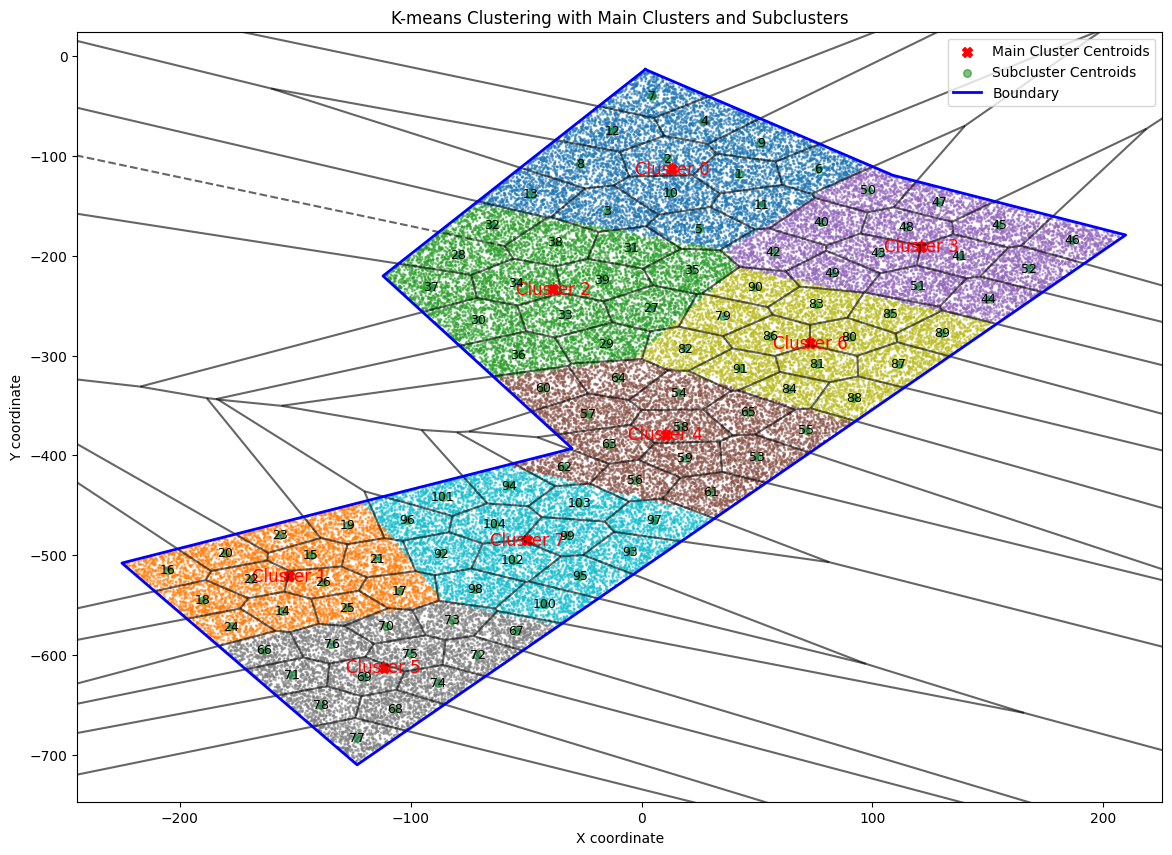

In [ ]:
# Plotting the clustering results with Voronoi diagram
fig, ax = plt.subplots(figsize=(14, 10))

# Plot all points
ax.scatter(points[:, 0], points[:, 1], c=cluster_labels_main, cmap='tab10', s=1, alpha=0.5)

# Plot centroids of main clusters
ax.scatter(kmeans_main.cluster_centers_[:, 0], kmeans_main.cluster_centers_[:, 1], c='red', s=50, marker='X', label='Main Cluster Centroids')

# Annotate main cluster centroids with cluster labels
for i, (x, y) in enumerate(kmeans_main.cluster_centers_):
    ax.text(x, y, f'Cluster {i}', fontsize=12, ha='center', va='center', color='red')

# Plot centroids of subclusters
ax.scatter(subclusters_centroid[:, 0], subclusters_centroid[:, 1], c='green', s=30, marker='o', label='Subcluster Centroids', alpha=0.5)

# Annotate subcluster centroids with numbers
for i, (x, y) in enumerate(subclusters_centroid):
    ax.text(x, y, str(subcluster_number[i]), fontsize=9, ha='center', va='center', color='black')

# Plot Voronoi diagram for subclusters
vor = Voronoi(subclusters_centroid)
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_width=1.5, line_alpha=0.6, point_size=2)

# Plot boundary
x, y = boundary.exterior.xy
ax.plot(x, y, color='blue', linewidth=2, label='Boundary')

ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_title('K-means Clustering with Main Clusters and Subclusters')
ax.legend()
plt.show()

In [ ]:
def run_pso_on_clusters(cluster_indices, cities, c1, c2, inertia_weight, start_city=None, end_city=None, iterations=1000, population_size=100, pbest_probability=0.9, gbest_probability=0.05):
    combined_cities = [cities[i] for i in cluster_indices]

    # Optionally add custom start and end cities
    if start_city:
        combined_cities.insert(0, start_city)
    if end_city:
        combined_cities.append(end_city)

    pso = PSO(iterations=iterations, population_size=population_size, c1=c1, c2=c2, inertia_weight=inertia_weight, pbest_probability=pbest_probability, gbest_probability=gbest_probability, cities=combined_cities, start_city=start_city, end_city=end_city)
    pso.run()

    # Ensure custom start and end points are preserved
    best_route = pso.gbest.pbest[:]
    if start_city and best_route[0] != start_city:
        best_route.remove(start_city)
        best_route.insert(0, start_city)
    if end_city and best_route[-1] != end_city:
        best_route.remove(end_city)
        best_route.append(end_city)

    return best_route

# Example to create city objects
cities = [City(x, y) for x, y in subclusters_centroid]


In [ ]:
# Example cluster combinations
cluster_combinations = {
    "Cluster 1 and 6": (0,3),
    "Cluster 4 and 2": (2,6),
    "Cluster 5": (4,),
    "Cluster 3": (7,),
    "Cluster 5 and 3": (1,5)
}

In [ ]:
# Initialize best solutions dictionary
best_solutions = {}

# PSO parameters
c1, c2, inertia_weight = 1.5, 2, 0.9  # example values for c1, c2, and inertia_weight
end_city = cities[77]  # Define the end city

# Define the order of processing cluster combinations
processing_order = [
    "Cluster 1 and 6",
    "Cluster 4 and 2",
    "Cluster 5",
    "Cluster 3",
    "Cluster 5 and 3"
]

# Function to find the closest subclusters between two sets of indices
def find_closest_subclusters(indices_a, indices_b, subclusters_centroid):
    min_distance = float('inf')
    closest_pair = None
    for i in indices_a:
        for j in indices_b:
            distance = np.linalg.norm(subclusters_centroid[i] - subclusters_centroid[j])
            if distance < min_distance:
                min_distance = distance
                closest_pair = (i, j)
    return closest_pair

# Run PSO for each cluster combination in the specified sequence
for name in processing_order:
    clusters = cluster_combinations[name]
    if len(clusters) == 1:  # Single cluster, no combination
        cluster_indices = np.where(subclusters_centroid_main_labels == clusters[0])[0]
        best_solution = run_pso_on_clusters(cluster_indices, cities, c1=c1, c2=c2, inertia_weight=inertia_weight)
        best_solutions[name] = best_solution
    else:  # Combination of two clusters
        cluster_a, cluster_b = clusters
        cluster_indices_a = np.where(subclusters_centroid_main_labels == cluster_a)[0]
        cluster_indices_b = np.where(subclusters_centroid_main_labels == cluster_b)[0]
        closest_subclusters = find_closest_subclusters(cluster_indices_a, cluster_indices_b, subclusters_centroid)
        combined_indices = list(cluster_indices_a) + list(cluster_indices_b)
        combined_indices.remove(closest_subclusters[0])
        combined_indices.remove(closest_subclusters[1])
        combined_indices = [closest_subclusters[0]] + combined_indices + [closest_subclusters[1]]
        start_city = cities[6] if name == "Cluster 1 and 6" else None
        end_city_to_use = end_city if name == "Cluster 5 and 3" else None
        best_solution = run_pso_on_clusters(combined_indices, cities, c1=c1, c2=c2, inertia_weight=inertia_weight, start_city=start_city, end_city=end_city_to_use)
        best_solutions[name] = best_solution

#Connect the best solutions from each combination to form the final route
final_route = []

for i, (name, solution) in enumerate(best_solutions.items()):
    if not final_route:
        final_route.extend(solution)
    else:
        last_city = final_route[-1]
        # Find the closest city in the new solution to the last city in the current final route
        min_distance = float('inf')
        closest_index = None

        for idx, city in enumerate(solution):
            if city not in final_route:
                distance = last_city.distance(city)
                if distance < min_distance:
                    min_distance = distance
                    closest_index = idx

        if closest_index is not None:
            new_route = solution[closest_index:] + solution[:closest_index]
            final_route.extend(new_route)

# Ensure start and end cities are correctly placed
if start_city:
    final_route.remove(start_city)
    final_route.insert(0, start_city)
if end_city:
    final_route.remove(end_city)
    final_route.append(end_city)

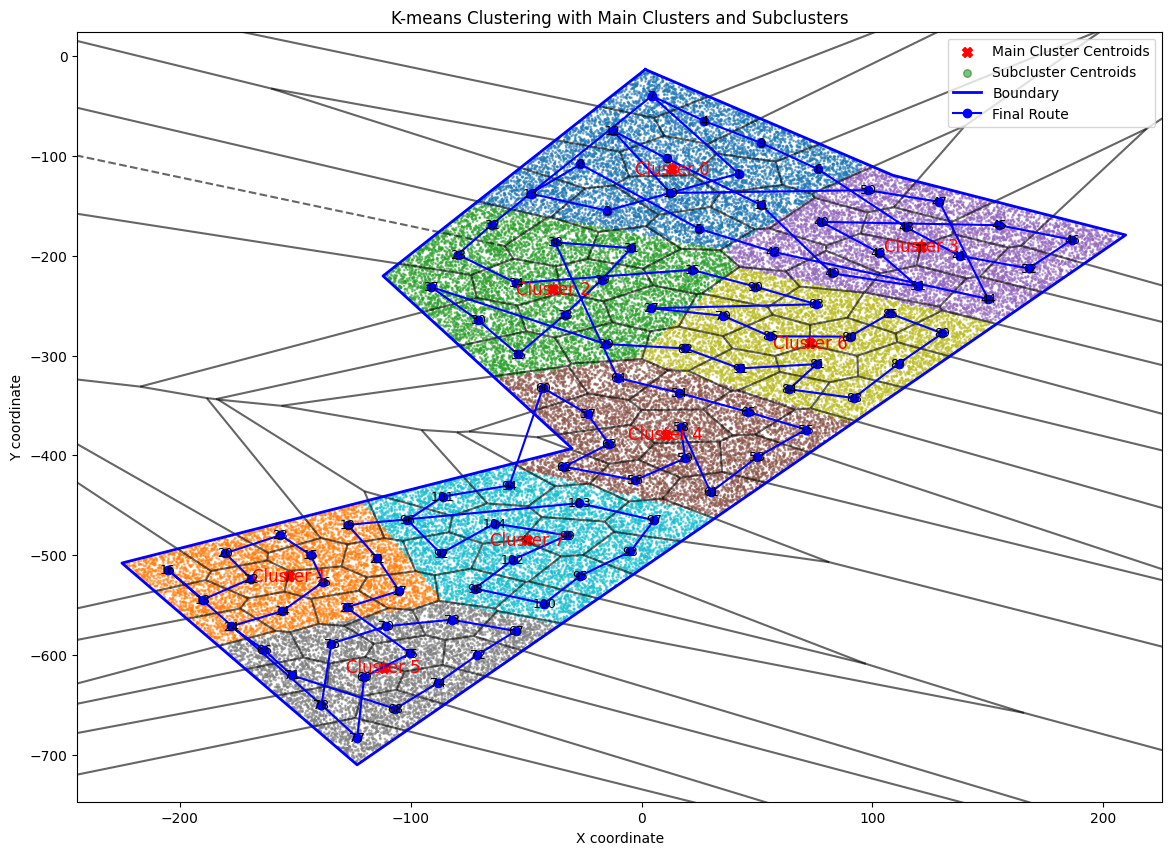

In [ ]:
# Plotting the clustering results with Voronoi diagram
fig, ax = plt.subplots(figsize=(14, 10))

# Plot all points
ax.scatter(points[:, 0], points[:, 1], c=cluster_labels_main, cmap='tab10', s=1, alpha=0.5)

# Plot centroids of main clusters
ax.scatter(kmeans_main.cluster_centers_[:, 0], kmeans_main.cluster_centers_[:, 1], c='red', s=50, marker='X', label='Main Cluster Centroids')

# Annotate main cluster centroids with cluster labels
for i, (x, y) in enumerate(kmeans_main.cluster_centers_):
    ax.text(x, y, f'Cluster {i}', fontsize=12, ha='center', va='center', color='red')

# Plot centroids of subclusters
ax.scatter(subclusters_centroid[:, 0], subclusters_centroid[:, 1], c='green', s=30, marker='o', label='Subcluster Centroids', alpha=0.5)

# Annotate subcluster centroids with numbers
for i, (x, y) in enumerate(subclusters_centroid):
    ax.text(x, y, str(subcluster_number[i]), fontsize=9, ha='center', va='center', color='black')

# Plot Voronoi diagram for subclusters
vor = Voronoi(subclusters_centroid)
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='black', line_width=1.5, line_alpha=0.6, point_size=2)

# Plot boundary
x, y = boundary.exterior.xy
ax.plot(x, y, color='blue', linewidth=2, label='Boundary')

# Plot the final connected route
x_list, y_list = [], []
for city in final_route:
    x_list.append(city.x)
    y_list.append(city.y)

ax.plot(x_list, y_list, 'bo-', label='Final Route')

ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_title('K-means Clustering with Main Clusters and Subclusters')
ax.legend()
plt.show()


In [ ]:
final_route_indices = [subclusters_centroid.tolist().index([city.x, city.y]) for city in final_route]
final_route_numbers = [subcluster_number[i] for i in final_route_indices]
print("Rute terbaik sebagai nomor subcluster:")
print(final_route_numbers)

Rute terbaik sebagai nomor subcluster:
[7, 4, 9, 6, 48, 41, 52, 46, 45, 40, 43, 51, 49, 11, 2, 12, 10, 50, 47, 44, 42, 5, 8, 13, 3, 1, 7, 32, 28, 34, 35, 90, 83, 27, 79, 86, 80, 85, 89, 87, 88, 84, 81, 91, 82, 29, 37, 30, 36, 33, 39, 31, 38, 64, 54, 65, 55, 53, 61, 58, 59, 56, 62, 63, 57, 60, 94, 101, 96, 92, 104, 99, 102, 98, 100, 95, 93, 97, 103, 19, 21, 17, 25, 75, 69, 77, 78, 76, 70, 73, 67, 72, 74, 68, 71, 66, 24, 14, 26, 15, 23, 20, 22, 18, 16, 78]


In [ ]:
# Print the best route cost
best_route_cost = path_cost(final_route)
print("Cost atau jarak rute terbaik:")
print(best_route_cost)

Cost atau jarak rute terbaik:
5375.805597251305
